# Building an AI Classifier: Identifying Cats, Dogs & Pandas with PyTorch

**Name :** BHAVATHARANI S

**Reg.No :** 212223230032

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models,datasets
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),      
    transforms.RandomHorizontalFlip(),  
    transforms.Resize(224),             
    transforms.CenterCrop(224),         
    transforms.ToTensor(),              
    transforms.Normalize([0.485, 0.456, 0.406],  
                         [0.229, 0.224, 0.225]) 
])

In [4]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
root = r"C:\Users\admin\deep\Cat-Dog_Pandas"

In [6]:
train_data = datasets.ImageFolder(os.path.join(root, 'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'Test'), transform=test_transform)

In [7]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['cat', 'dog', 'panda']
Training images available: 2100
Testing images available:  601


In [8]:
ResNet18model = models.resnet18(pretrained=True)

In [9]:
ResNet18model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
for param in ResNet18model.parameters():
    param.requires_grad = False  # freeze all convolutional layers

num_features = ResNet18model.fc.in_features  # 512 for ResNet18

ResNet18model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3)   # 3 classes: cat, dog, panda
)

In [11]:
ResNet18model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
for param in ResNet18model.parameters():
    print(param.numel())

9408
64
64
36864
64
64
36864
64
64
36864
64
64
36864
64
64
73728
128
128
147456
128
128
8192
128
128
147456
128
128
147456
128
128
294912
256
256
589824
256
256
32768
256
256
589824
256
256
589824
256
256
1179648
512
512
2359296
512
512
131072
512
512
2359296
512
512
2359296
512
512
131072
256
768
3


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ResNet18model.fc.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the model to the device
ResNet18model = ResNet18model.to(device)

Using device: cuda


In [14]:
import time
import torch
epochs = 3 
max_trn_batch = 800   
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

start_time = time.time()


for i in range(epochs):
    ResNet18model.train() 
    trn_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break

        X_train, y_train = X_train.to(device), y_train.to(device)


        y_pred = ResNet18model(X_train)
        loss = criterion(y_pred, y_train)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr


        if (b+1) % 200 == 0:
            print(f'epoch: {i+1:2}  batch: {b+1:4} [{(b+1)*10:6}/2100]  '
                  f'loss: {loss.item():10.8f}  '
                  f'accuracy: {trn_corr.item()*100/((b+1)*train_loader.batch_size):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())


    ResNet18model.eval() 
    tst_corr = 0

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            X_test, y_test = X_test.to(device), y_test.to(device)

            y_val = ResNet18model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

        loss_val = criterion(y_val, y_test)
        test_losses.append(loss_val.item())
        test_correct.append(tst_corr.item())

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  1  batch:  200 [  2000/2100]  loss: 0.44460574  accuracy:  87.050%
epoch:  2  batch:  200 [  2000/2100]  loss: 0.01885596  accuracy:  92.100%
epoch:  3  batch:  200 [  2000/2100]  loss: 0.00700090  accuracy:  92.600%

Duration: 185 seconds


In [15]:
best_val_acc = 0.0  # initialize best validation accuracy

val_acc = tst_corr.item() / len(test_data)  # calculate validation accuracy
if val_acc > best_val_acc:
    best_val_acc = val_acc
    torch.save(ResNet18model.state_dict(), 'best_resnet18_model.pth')
    print(f"Saved best model at epoch {i+1} with val_acc = {val_acc*100:.2f}%")

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Saved best model at epoch 3 with val_acc = 96.84%

Duration: 252 seconds


In [16]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1]*100/len(test_data):.3f}%')

[562, 578, 582]
Test accuracy: 96.839%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].


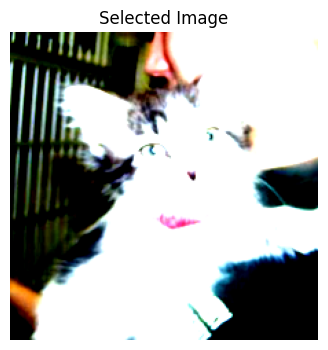

True class: cat
Predicted class: cat


In [18]:
image_index = 150
img, label = test_data[image_index]

plt.figure(figsize=(4, 4))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title("Selected Image")
plt.show()

# Evaluate model
ResNet18model.eval()
with torch.no_grad():
    img_input = img.unsqueeze(0).to(device)
    pred = ResNet18model(img_input).argmax(dim=1)

predicted_class = class_names[pred.item()]
true_class = class_names[label]

print(f"True class: {true_class}")
print(f"Predicted class: {predicted_class}")

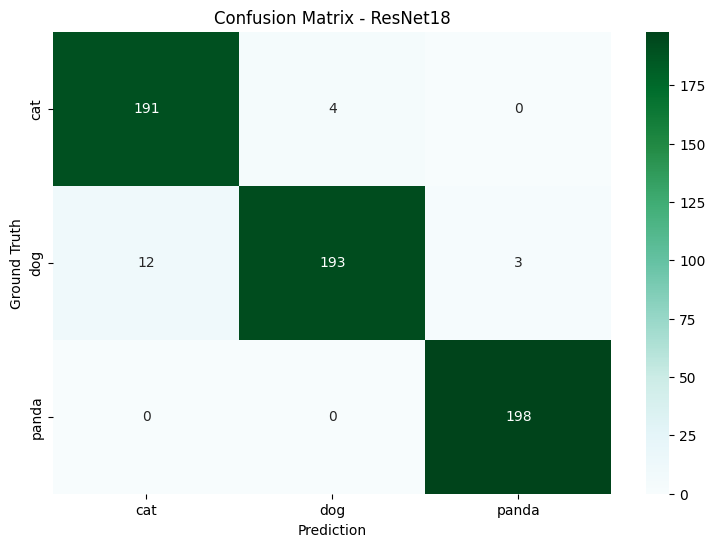

In [19]:
test_load_all = DataLoader(test_data, batch_size=20, shuffle=False)

all_preds = []
all_labels = []

ResNet18model.eval()
with torch.no_grad():
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_val = ResNet18model(X_test)
        predicted = torch.max(y_val, 1)[1]

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())


import seaborn as sns
arr = confusion_matrix(all_labels, all_preds)



df_cm = pd.DataFrame(arr, index=class_names, columns=class_names)

plt.figure(figsize=(9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix - ResNet18")
plt.show()

In [ ]:
torch.save(ResNet18model.state_dict(), "resnet18_catdogpanda.pth")

print("Model saved as resnet18_catdogpanda.pth")